In [1]:
import math
import numpy as np
import folium
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from geopy.distance import distance
from math import radians, sin, cos, sqrt, tan, atan, atan2, degrees

# 1. Calculating the FOV of the Main Camera on Samsung Note 20 Ultra

## 1.1. Technical Data of the Main Camera
- **Focal length:** 26 mm (equivalent **35mm film format**, also known as **full-frame format** in digital photography.).
- To calculate the Field of View (FOV) for the Samsung Note 20 Ultra using the full-frame format equivalent, we will treat its reported focal lengths (**26mm for main wide**, 13mm for ultra-wide, and 120mm for telephoto) as "35mm equivalent focal lengths." This means we will use the standard **full-frame dimensions** of **36mm × 24mm** as the sensor size.

## 1.2. FOV Calculation Formula
$$
\text{FOV} = 2 \cdot \arctan\left(\frac{\text{sensor size}}{2 \cdot \text{focal length}}\right)
$$

- Horizontal FOV (hFOV):
$$
\text{hFOV} = 2 \cdot \arctan\left(\frac{\text{Sensor width}}{2 \cdot \text{focal length}}\right)
$$

- Vertical FOV (vFOV):
$$
\text{vFOV} = 2 \cdot \arctan\left(\frac{\text{sensor height}}{2 \cdot \text{focal length}}\right)
$$

- Diagonal FOV (dFOV):
$$
\text{dFOV} = 2 \cdot \arctan\left(\frac{\text{sensor diagonal}}{2 \cdot \text{focal length}}\right)
$$

In [2]:
def calculate_fov(sensor_size, focal_length):
    """
    Calculate the Field of View (FOV).

    :param sensor_size: Size of the sensor (in mm).
    :param focal_length: Focal length of the lens (in mm).
    :return: FOV in degrees.
    """
    fov = 2 * degrees(atan(sensor_size / (2 * focal_length)))
    return fov

In [3]:
# Sensor dimensions and focal length in mm
sensor_diagonal = sqrt(36**2 + 24**2)
sensor_ratio = (4, 3)   # Aspect ratio of the sensor
sensor_height = sensor_diagonal * (sensor_ratio[0] / sqrt(sensor_ratio[0]**2 + sensor_ratio[1]**2))
sensor_width = sensor_diagonal * (sensor_ratio[1] / sqrt(sensor_ratio[0]**2 + sensor_ratio[1]**2))
focal_length = 26

# Calculate FOVs
hfov = calculate_fov(sensor_width, focal_length)   # Horizontal FOV
vfov = calculate_fov(sensor_height, focal_length)  # Vertical FOV
dfov = calculate_fov(sensor_diagonal, focal_length)  # Diagonal FOV

# Print results
print("Horizontal FOV:", round(hfov, 2), "degrees")
print("Vertical FOV:", round(vfov, 2), "degrees")
print("Diagonal FOV:", round(dfov, 2), "degrees")

Horizontal FOV: 53.06 degrees
Vertical FOV: 67.3 degrees
Diagonal FOV: 79.52 degrees


If the camera uses a **16:9 aspect ratio** (in video mode), it will indeed crop the image in 4:3 (=16:12) format to create a 16:9 format. In this case:

- The **hFOV** will be smaller and **vFOV** will get the same value.

- The diagonal field of view (dFOV) can be calculated using the relationship between the horizontal, vertical, and diagonal dimensions of the cropped sensor:

$$
\text{dFOV} = 2 \times \arctan\left(\frac{\sqrt{(\text{Sensor Width})^2 + (\text{Sensor Height})^2}}{2 \times \text{Focal Length}}\right)
$$

In [4]:
sensor_height_16_9 = sensor_height
vfov_16_9 = vfov

sensor_width_16_9 = sensor_width * 9/12
hfov_16_9 = calculate_fov(sensor_width_16_9, focal_length)

dfov_16_9 = 2 * degrees(atan(sqrt(sensor_width_16_9**2 + sensor_height_16_9**2) / (2*focal_length)))

# Print results
print("Horizontal FOV in a 16:9 aspect ratio:", round(hfov_16_9, 2), "degrees")
print("Vertical FOV in a 16:9 aspect ratio:", round(vfov_16_9, 2), "degrees")
print("Diagonal FOV in a 16:9 aspect ratio:", round(dfov_16_9, 2), "degrees")

Horizontal FOV in a 16:9 aspect ratio: 41.05 degrees
Vertical FOV in a 16:9 aspect ratio: 67.3 degrees
Diagonal FOV in a 16:9 aspect ratio: 74.74 degrees


## 1.3. Procedure for using Compass and taking photos of the sky
1. Determine the direction (before setting up the phone): Place the phone **parallel to the ground**.

2. Set up the phone to take photos:

- Once we know the center direction, we can set up the phone at the appropriate angle to take photos of the sky.

- How to set up: **Slightly tilt** because we want to cover the entire horizon.

**Reasons not to use Compass when the phone is upright**
- When the phone is upright, the magnetic field sensor measuring the **vertical** direction is unreliable due to magnetic interference in other directions.

- The result may be skewed, affecting the accuracy of calculating the boundary angle.


## 1.4. Calculating Left and Right Boundary Angles and Coordinates
- Central orientation (θc): mesured by Compass.
- Left boundary angle (θ_left):
$$
\theta_{\text{left}} = \theta_c - \frac{\text{hFOV}}{2}
$$
- Right boundary angle (θ_right):
$$
\theta_{\text{right}} = \theta_c + \frac{\text{hFOV}}{2}
$$

In [5]:
def calculate_boundary_angles(center_angle, fov):
    """
    Calculate the left and right boundary angles based on the center angle and FOV.

    :param center_angle: Center orientation angle (in degrees).
    :param fov: Field of View (in degrees).
    :return: Left and right angles.
    """
    left_angle = center_angle - (fov / 2)
    right_angle = center_angle + (fov / 2)
    return left_angle, right_angle

We choose the direction of observation so that it is **perpendicular** to a flight path.

<img src="flight map.png" alt="Flight Map" width="600"/>

In [6]:
# Center orientation angle
center_orientation = (302 + 127) / 2  # in degrees
print("Center orientation:", center_orientation, "degrees")

# Calculate left and right boundary angles
left_angle, right_angle = calculate_boundary_angles(center_orientation, hfov_16_9)

print("Left boundary angle:", round(left_angle, 2), "degrees")
print("Right boundary angle:", round(right_angle, 2), "degrees")

Center orientation: 214.5 degrees
Left boundary angle: 193.97 degrees
Right boundary angle: 235.03 degrees


 **Change latitude $( \Delta \text{lat} $):**

$$
\Delta \text{lat} = \frac{D}{R} \cdot \cos(\theta)
$$

 **Change longitude ($ \Delta \text{lon} $):**

$$
\Delta \text{lon} = \frac{D}{R \cdot \cos(\text{latitude})} \cdot \sin(\theta)
$$

- $ D $: Maximum observation distance (in meters).

- $ R $: Earth radius (6,371 km = 6,371,000 m).

- $ \theta $: Angle (left or right edge direction, in radians).

- $ \text{latitude} $: Current latitude of the camera.

In [7]:
def calculate_gps_coordinates(lat0, lon0, distance, angle, earth_radius=6_371_000):
    """
    Calculate GPS coordinates based on distance and angle.
    
    :param lat0: Initial latitude in degrees.
    :param lon0: Initial longitude in degrees.
    :param distance: Distance in meters.
    :param angle: Angle in degrees.
    :param earth_radius: Radius of the Earth in meters (default is 6,371,000 m).
    :return: New latitude and longitude in degrees.
    """
    angle_rad = radians(angle)
    lat0_rad = radians(lat0)
    lon0_rad = radians(lon0)
    
    delta_lat = (distance / earth_radius) * cos(angle_rad)
    new_lat = lat0_rad + delta_lat
    
    delta_lon = (distance / (earth_radius * cos(lat0_rad))) * sin(angle_rad)
    new_lon = lon0_rad + delta_lon
    
    return degrees(new_lat), degrees(new_lon)

In [8]:
# Function to calculate GPS coordinates based on distance and angle
def calculate_coordinates(lat, lon, dist, angle):
    """
    Calculate new GPS coordinates based on distance and angle.
    :param lat: Latitude of the starting point.
    :param lon: Longitude of the starting point.
    :param dist: Distance in meters.
    :param angle: Angle in degrees (bearing).
    :return: Tuple of new latitude and longitude.
    """
    point = distance(meters=dist).destination((lat, lon), bearing=angle)
    return point.latitude, point.longitude

## 1.5. Maximum observable distance: 

$$ D = \sqrt{2 \cdot R \cdot h} $$

1. **Geometric model**:
- The Earth is considered a sphere with radius $ R $.

- An observation point at height $ h $ is located outside the Earth's surface.

- The horizon is defined as the intersection of a straight line passing through the observer's eye and the Earth's surface.

2. **Geometric equation**:

- From the Pythagorean theorem, with a right triangle formed by:

- $ R $: Radius of the Earth.

- $ R + h $: Distance from the center of the Earth to the observation point.

- $ D $: Distance from the observation point to the horizon.

- Relation: $(R + h)^2 = R^2 + D^2$.

3. **Simplify**:
- Since $ h \ll R $ (the height is much smaller than the radius of the Earth), we can approximate $R + h \approx R$, then:
$$
D^2 \approx 2 \cdot R \cdot h
$$

In [9]:
# Current GPS coordinates
lat1, lon1 = 43.57072605547293, 1.4682620342267738

# Maximum observation distance from a high floor
observation_distance = sqrt(2 * 6_371_000 * 16)  # meters
print("Observable distance:", observation_distance)

# Calculate GPS coordinates for left and right boundaries
left_coordinates = calculate_gps_coordinates(lat1, lon1, observation_distance, left_angle)
right_coordinates = calculate_gps_coordinates(lat1, lon1, observation_distance, right_angle)

# Print results
print("Current GPS coordinates:", (lat1, lon1))
print("Left boundary GPS coordinates:", left_coordinates)
print("Right boundary GPS coordinates:", right_coordinates)

Observable distance: 14278.37525771052
Current GPS coordinates: (43.57072605547293, 1.4682620342267738)
Left boundary GPS coordinates: (43.44611717806291, 1.425467002274119)
Right boundary GPS coordinates: (43.49712360251506, 1.3230345133147507)


In [10]:
# Calculate boundary coordinates
boundary_points = []
for angle in range(int(left_angle), int(right_angle) + 1):
    boundary_points.append(calculate_gps_coordinates(lat1, lon1, observation_distance, angle))

# Add starting and ending points to close the polygon
boundary_points.insert(0, (lat1, lon1))
boundary_points.append((lat1, lon1))

# Create a folium map
m = folium.Map(location=[lat1, lon1], zoom_start=12)

# Add Camera 1 observation area
folium.Polygon(
    locations=boundary_points,
    color="blue",
    weight=2,
    fill=True,
    fill_color="blue",
    fill_opacity=0.4,
    popup="Camera 1 Area"
).add_to(m)

# Add a marker for the starting point
folium.Marker([lat1, lon1], popup="Camera 1", icon=folium.Icon(color="red")).add_to(m)

# Display map
m

# 2. Optimizing Cameras Distance for Aircraft Position Observation and Calculation

## 2.1. Problem Definition

![1](2.png)

In this problem, we have three main points:
- O₁, O₂: positions of two cameras
- M: aircraft position

The goal is to find the appropriate distance between two cameras for efficient observation and calculation of aircraft position.

Notation:
- d: distance between two cameras (O₁O₂)
- h: aircraft/contrails altitude
- $r_{1,2}$: distance from camera(1,2) to aircraft
- w: contrail thickness
- p: number of pixels displaying contrail
- $\phi_{1,2}$: angle between camera-aircraft line and horizontal plane (in degrees)
- R: camera vertical resolution
- α: camera vertical field of view (vFOV)

To simplify the calculation, in this section, we will assume $\phi_1 = \phi_2 = \phi$. This assumption is reasonable, because if $\phi_1 > \phi_2$, we can move camera 2 closer to increase the value of $\phi_2$ while still ensuring observation. The cameras distance will be shorter.

## 2.2. Variables Analysis

### 2.2.1. Aircraft altitude $h$

- Contrails are usually formed at heights of **8-12km**. So in this section, we will consider $h = 12$ km to calculate the distance between 2 cameras to ensure observation of most contrails (if contrails at this altitude are well observed, lower contrails are also well observed).
- $h$ is calculated using the formula:
$$
h = r \cdot sin(\phi)
$$
Next, we will find the optimal values ​​for these two parameters.

### 2.2.1. Effect of Camera-Aircraft Distances ($r_{1,2}$) on Contrail Pixel Display

The larger $r$ is, the smaller contrail images are, reducing the number of pixels used to display the contrail.

Formula for calculating pixels across contrail thickness:
$$
p = \frac{w}{r} \cdot \frac{R}{2 \tan\left(\frac{\alpha}{2}\right)}
$$

Where:
- w = 200-400m (according to [FAA](https://www.faa.gov/sites/faa.gov/files/regulations_policies/policy_guidance/envir_policy/contrails.pdf)). Moreover, we are more concerned with old contrails that have existed for some time and spread. Choosing the minimum value of 200m helps examine the most challenging case.
- R = 3840 (4K camera)
- α = 67.3°

Therefore, to make the contrails appear clearly on the image, we need to **increase $\phi$**, to decrease r and thus increase the number of pixels.

Example with $\phi$ = 60° and h = 12000m:

In [11]:
def calculate_pixel(w, h, phi, R, alpha):
    """
    Calculate the pixel value based on the given parameters:
    
    Args:
        w (float): Contrails thickness.
        h (float): Altitude of the aircraft/contrails.
        phi (float): angle between camera-aircraft line and horizontal plane (in degrees).
        R (float): Resolution.
        alpha (float): Vertical field of view (vfov) of the camera in degrees.

    Returns:
        int: Calculated pixel value, rounded up to the nearest integer.
    """
    # Convert angles from degrees to radians
    alpha_rad = radians(alpha)
    phi_rad = radians(phi)

    # Calculate r from h and phi
    r = h / sin(phi_rad)

    # Calculate the pixel value using the formula
    pixel = (w / r) * (R / (2 * tan(alpha_rad / 2)))
    
    # Return the pixel value rounded up to the nearest integer
    return math.ceil(pixel)

print(calculate_pixel(200, 12000, 60, 3840, vfov_16_9), "pixels")

42 pixels


### 2.2.3. Effect of $\phi$ and on Cameras Distance Accuracy

When $d$ is small, we need to increase angles $\phi$ to observe contrails. The cameras distance is calculated using the formula:
$$
d = \frac{h}{tan(\phi_1)} +\frac{h}{tan(\phi_2)} = 2 \cdot \frac{h}{tan(\phi)}
$$

However, when $\phi$ > 70°, the tan(x) function curve increases very rapidly. Therefore, to avoid errors in calculation, we need to **limit the value of $\phi$**.

![3](3.png)



Example with $\phi$ = 60° and h = 12000m:

In [12]:
def calculate_camera_distance(h, phi):
    """
    Calculate the distance between two cameras based on the contrails altitude and angle phi.

    Args:
        h (float): Altitude of the contrails/aircrafts in meters.
        phi (float): angle between camera-aircraft line and horizontal plane (in degrees).

    Returns:
        float: Distance between two cameras in meters.
    """
    # Convert phi from degrees to radians
    phi_rad = radians(phi)

    # Calculate the distance between two cameras
    distance = 2 * (h / tan(phi_rad))
    return distance

# Calculate distance
distance = calculate_camera_distance(12000, 60)
print(f"Distance between cameras: {distance:.2f} m")

Distance between cameras: 13856.41 m


## 2.3. Case Comparisons

Here, we test with $\phi_1$ and $ \phi_2 $ less than $ 70^\circ $ to avoid significant error impact, but not too small to prevent the distance between the aircraft and the two cameras from becoming too large, which would reduce the number of pixels representing the contrail. We consider three cases here with $\phi_1 = \phi_2 = \phi \in \{60^\circ, 65^\circ, 70^\circ\} $.

| Angle φ | Distance d (m) | Pixels p |
|---------|---------------|----------|
| 60°     | 13856         | 42       |
| 65°     | 11191         | 44       |
| 70°     | 8735          | 45       |


## 2.4. Conclusion

From the above table, we can observe:
1. Increasing d => increases r, leading to decreased p
2. Decreasing d => increases φ, potentially causing large errors when φ > 70°

To balance between pixel display and error potential, we choose φ = 65°. At this angle:
- p = 44 pixels: sufficient for effective contrail analysis
- φ is small enough to limit errors in height calculation
- d ≈ 11191m: reasonable distance for practical deployment



In [13]:
# Calculate distance
optimal_distance = calculate_camera_distance(12000, 65)
print(f"Optimal distance between cameras: {optimal_distance:.2f} m")

Optimal distance between cameras: 11191.38 m


In [14]:
center_orientation1 = center_orientation

# Calculate new camera 2 position
lat2, lon2 = calculate_gps_coordinates(lat1, lon1, optimal_distance, center_orientation1)

# Calculate new camera 2 orientation
center_orientation2 = (center_orientation1 + 180) % 360

# Print results
print("Camera 2 GPS Coordinates:", (lat2, lon2))
print("Camera 2 Orientation:", round(center_orientation2, 2), "degrees")

Camera 2 GPS Coordinates: (43.487780612265304, 1.389580286057059)
Camera 2 Orientation: 34.5 degrees


In [15]:
# Calculate Camera 2 boundary
left_angle2, right_angle2 = calculate_boundary_angles(center_orientation2, hfov)
boundary_points2 = [calculate_gps_coordinates(lat2, lon2, observation_distance, angle) for angle in range(int(left_angle2), int(right_angle2) + 1)]
boundary_points2.insert(0, (lat2, lon2))
boundary_points2.append((lat2, lon2))

# Add Camera 2 observation area
folium.Polygon(
    locations=boundary_points2,
    color="green",
    weight=2,
    fill=True,
    fill_color="green",
    fill_opacity=0.4,
    popup="Camera 2 Area"
).add_to(m)

# Add markers for camera locations
folium.Marker([lat2, lon2], popup="Camera 2", icon=folium.Icon(color="blue")).add_to(m)

# Display map
m

# 3. Estimate Aircraft Positioning in 3D Space from Image Data



## 3.1. Problem Overview

### Objective
- Determine the coordinates $(x, y, z)$ of the aircraft in 3D space.
- Use data from **2 fixed cameras** at known positions.
- Compute the **estimated coordinates** of the aircraft relative to sea level.

### Input
- Geographic coordinates (latitude, longitude) and altitude of 2 cameras: $(lat_1, lon_1, alt_1), (lat_2, lon_2, alt_2)$.
- Camera specifications:
  - Resolution: $(W, H)$ (pixels).
  - Horizontal Field of View (hFOV) and Vertical Field of View (vFOV).
  - Tilt angle: $(\theta_\text{tilt})$.
- Pixel coordinates of the aircraft on the images from 2 cameras: $((px_1, py_1), (px_2, py_2))$.

### Output
- Position of the aircraft $(x, y, z)$ in 3D space.
- Estimated altitude $(z_\text{real})$ of the aircraft.
- Distance from the aircraft to each camera.
- Viewing angles from each camera to the aircraft.


## 2. Coordinate System and Reference Plane

### Coordinate System $Oxyz$
- Origin $O$: The projection point of camera 1 onto the plane \(z = 0\).
- **X-axis**: The line connecting the projections of the two cameras on the \(z = 0\) plane.
- **Z-axis**: The vertical direction, perpendicular to sea level.
- **Y-axis**: Perpendicular to the \(xOz\) plane, following the right-hand rule.

### Reference Plane \(z = 0\)
- Coincides with the **Mean Sea Level (MSL)**.
- All altitudes are calculated relative to this plane:
  - **Camera 1**: \((0, 0, alt_1)\).
  - **Camera 2**: \((D, 0, alt_2)\), where \(D\) is the geographic distance.



## 3.3. Useful functions

### 3.3.1 Distance Between the Two Points

#### **Haversine Formula**
The distance $D$ between two points on the surface of a sphere is calculated using the following formula:
$$
D = R \cdot c
$$
Where:
- $R = 6371000 \, \text{m}$ is the Earth's radius (in meters).
- $c = 2 \cdot \arctan2\left(\sqrt{a}, \sqrt{1-a}\right)$.
- $a = \sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\Delta \lambda}{2}\right)$.
- $\Delta \phi = \phi_2 - \phi_1$ is the latitude difference (radians).
- $\Delta \lambda = \lambda_2 - \lambda_1$ is the longitude difference (radians).

#### **3D Distance Calculation**
To calculate the distance between two points in 3D space, we need to include the altitude (height) difference between the two points:
$$
\text{distance} = \sqrt{(\text{ground distance})^2 + (\text{altitude difference})^2}
$$
Where:
- **ground distance** is calculated using the Haversine formula as described above.
- **altitude difference** is the difference in height between the two points: $alt_2 - alt_1$.

In [16]:
def calculate_distance(lat1, lon1, alt1, lat2, lon2, alt2, earth_radius=6371000):
    """
    Calculate the 3D distance between two points with latitude, longitude, and altitude.
    
    Parameters:
        lat1, lon1, alt1: Latitude, longitude (in degrees), and altitude (in meters) of the first point.
        lat2, lon2, alt2: Latitude, longitude (in degrees), and altitude (in meters) of the second point.
        earth_radius: Radius of the Earth in meters (default is 6371000 meters).
    
    Returns:
        The 3D distance in meters.
    """
    # Convert degrees to radians
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = sin(dlat/2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    # Ground distance
    ground_distance = earth_radius * c

    # Calculate the 3D distance
    height_diff = alt2 - alt1
    distance = sqrt(ground_distance**2 + height_diff**2)
    return distance

### 3.3.2. Angle between the camera-aircraft line and referenced directions

- The horizontal angle between the camera-aircraft line and center orientation ($\alpha$):
$$
\alpha = -\arctan\left[\frac{(px - W/2)}{W/2} \cdot \tan(\text{hFOV}/2)\right]
$$

- The vertical angle between the camera-aircraft line and ground ($\beta$):
$$
\beta = \theta_\text{tilt} + \arctan\left[\frac{(py - H/2)}{H/2} \cdot \tan(\text{vFOV}/2)\right]
$$

In [17]:
def calculate_angles(pixel, resolution, hfov, vfov, tilt_angle):
    hfov_rad = radians(hfov)
    vfov_rad = radians(vfov)
    tilt_angle_rad = radians(tilt_angle)

    # Calculate alpha angle (horizontal)
    alpha = -atan((pixel[0] - resolution[0]/2) / (resolution[0]/2) * tan(hfov_rad/2))

    # Calculate beta angle (vertical)
    beta = tilt_angle_rad + atan((pixel[1] - resolution[1]/2) / (resolution[1]/2) * tan(vfov_rad/2))

    return alpha, beta

### 3.3.3. Direction Vector from Camera to Aircraft

Direction Vector $M$: from angles $\alpha$ and $\beta$, construct the unit vector $M = [\cos\theta_x, \cos\theta_y, \cos\theta_z]$.

- Camera 1:
$$
\cos\theta_x = \sqrt{1 - \sin^2\alpha - \sin^2\beta}, \, \cos\theta_y = \sin\alpha, \, \cos\theta_z = \sin\beta
$$

- Camera 2:
$$
\cos\theta_x = -\sqrt{1 - \sin^2\alpha - \sin^2\beta}, \, \cos\theta_y = -\sin\alpha, \, \cos\theta_z = \sin\beta
$$





In [18]:
def calculate_direction_vector(alpha, beta, is_camera2=False):
    if not is_camera2:
        costhetax = sqrt(1 - sin(alpha)**2 - sin(beta)**2)
        costhetay = sin(alpha)
        costhetaz = sin(beta)
    else:
        costhetax = -sqrt(1 - sin(alpha)**2 - sin(beta)**2)
        costhetay = -sin(alpha)
        costhetaz = sin(beta)
    
    return np.array([costhetax, costhetay, costhetaz])

### 3.3.4. Determining the Aircraft’s Position

**Line Equation**:
The line equations for each camera:
$$
L_1: P_1 + t \cdot M_1, \quad L_2: P_2 + s \cdot M_2
$$
- $(P_1, P_2)$: The positions of the cameras.
- $(M_1, M_2)$: The direction vectors.
- $(t, s)$: The parameters of the lines.

**Closest Points Between the Two Lines**:
The closest point of intersection (if any) is determined by:
$$
t = \frac{\text{dot}(\text{cross}(v, M_2), \text{cross}(M_1, M_2))}{|\text{cross}(M_1, M_2)|^2}
$$
$$
s = \frac{\text{dot}(\text{cross}(v, M_1), \text{cross}(M_1, M_2))}{|\text{cross}(M_1, M_2)|^2}
$$
Where:
- $v = P_2 - P_1$.
- $\text{dot}$: Dot product.
- $\text{cross}$: Cross product.

**Estimated Position of the Aircraft**:
The position of the aircraft is the midpoint between the closest points:
$$
(x, y, z) = \frac{(P_1 + t \cdot M_1) + (P_2 + s \cdot M_2)}{2}
$$



In [19]:
def find_closest_point(P1, P2, M1, M2):
    v = P2 - P1
    t = np.dot(np.cross(v, M2), np.cross(M1, M2)) / np.linalg.norm(np.cross(M1, M2))**2
    s = np.dot(np.cross(v, M1), np.cross(M1, M2)) / np.linalg.norm(np.cross(M1, M2))**2
    
    Pc1 = P1 + t * M1
    Pc2 = P2 + s * M2
    
    return (Pc1 + Pc2) / 2

### 3.3.7. Test these functions

In [20]:
alt1, alt2 = 1000, 1000
pixel1, pixel2 = (1020, 1160), (5040, 2320)
resolution1, resolution2 = (3840, 2160), (7680, 4320)
hfov1, vfov1, hfov2, vfov2 = 53.06, 67.3, 53.06, 67.3
tilt_angle1, tilt_angle2 = 55, 55

# Calculate the distance between the two cameras. It must be close to 11191.38 m
D = calculate_distance(lat1, lon1, alt1, lat2, lon2, alt2)
D = optimal_distance

# The camera positions in Oxyz
camera1_pos = np.array([0, 0, alt1])
camera2_pos = np.array([D, 0, alt2])

# Calculate the angles alpha and beta for both cameras
alpha1, beta1 = calculate_angles(pixel1, resolution1, hfov1, vfov1, tilt_angle1)
alpha2, beta2 = calculate_angles(pixel2, resolution2, hfov2, vfov2, tilt_angle2)

# Calculate the direction vectors for both cameras
M1 = calculate_direction_vector(alpha1, beta1)
M2 = calculate_direction_vector(alpha2, beta2, is_camera2=True)

# Find the closest point (aircraft position)
aircraft_position = find_closest_point(camera1_pos, camera2_pos, M1, M2)

# Calculate the distance from the aircraft to each camera
distance_to_camera1 = np.linalg.norm(aircraft_position - camera1_pos)
distance_to_camera2 = np.linalg.norm(aircraft_position - camera2_pos)

print(f"Camera 1 position: ({camera1_pos[0]:.2f}, {camera1_pos[1]:.2f}, {camera1_pos[2]:.2f})")
print(f"Camera 2 position: ({camera2_pos[0]:.2f}, {camera2_pos[1]:.2f}, {camera2_pos[2]:.2f})")
print(f"Distance between the two cameras: {D:.2f} meters")
print(f"Aircraft position (absolute): ({aircraft_position[0]:.2f}, {aircraft_position[1]:.2f}, {aircraft_position[2]:.2f}) meters")
print(f"Aircraft height: {aircraft_position[2]:.2f} meters")
print(f"Distance from the aircraft to camera 1: {distance_to_camera1:.2f} meters")
print(f"Distance from the aircraft to camera 2: {distance_to_camera2:.2f} meters")

Camera 1 position: (0.00, 0.00, 1000.00)
Camera 2 position: (11191.38, 0.00, 1000.00)
Distance between the two cameras: 11191.38 meters
Aircraft position (absolute): (5383.84, 2141.10, 10505.22) meters
Aircraft height: 10505.22 meters
Distance from the aircraft to camera 1: 11131.90 meters
Distance from the aircraft to camera 2: 11342.88 meters


## 3.4. Display the aircraft position in $Oxyz$ and in $GPS$

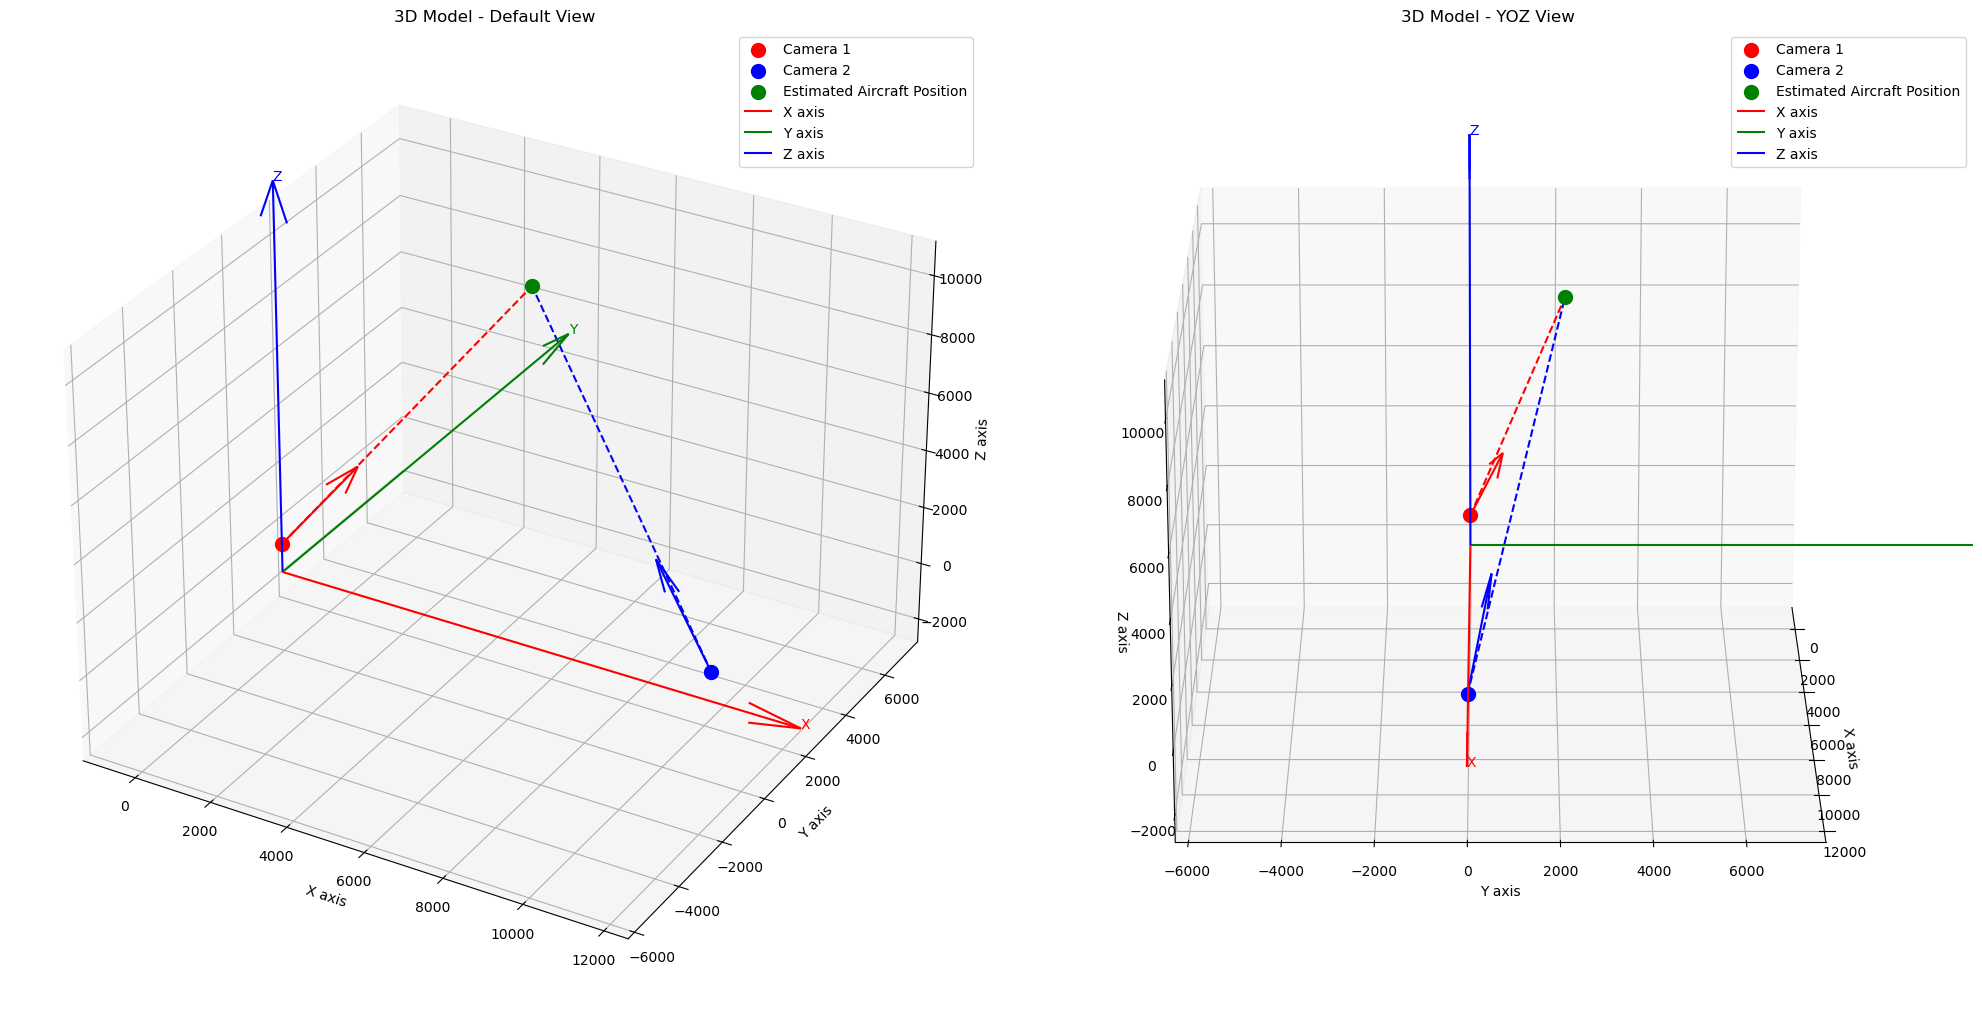

In [21]:
def plot_3d_model(D, aircraft_position, M1, M2, camera1_pos, camera2_pos):
    fig = plt.figure(figsize=(20, 10))
    
    # Subplot 1: Default view
    ax1 = fig.add_subplot(121, projection='3d')
    plot_subplot(ax1, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, "Default View")
    
    # Subplot 2: YOZ view
    ax2 = fig.add_subplot(122, projection='3d')
    plot_subplot(ax2, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, "YOZ View")
    ax2.view_init(elev=20, azim=0)
    
    plt.tight_layout()
    plt.show()

def plot_subplot(ax, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, view_title):
    # Set scale factor based on camera distance
    scale = D * 0.3  # You can adjust this multiplier to change the relative length

    # Plot cameras
    ax.scatter(*camera1_pos, color='r', s=100, label='Camera 1')
    ax.scatter(*camera2_pos, color='b', s=100, label='Camera 2')

    # Plot camera direction vectors
    ax.quiver(*camera1_pos, *(M1 * scale), color='r')
    ax.quiver(*camera2_pos, *(M2 * scale), color='b')

    # Plot estimated aircraft position
    ax.scatter(*aircraft_position, color='g', s=100, label='Estimated Aircraft Position')

    # Connect cameras to aircraft position
    ax.plot([camera1_pos[0], aircraft_position[0]], 
            [camera1_pos[1], aircraft_position[1]], 
            [camera1_pos[2], aircraft_position[2]], 'r--')
    ax.plot([camera2_pos[0], aircraft_position[0]], 
            [camera2_pos[1], aircraft_position[1]], 
            [camera2_pos[2], aircraft_position[2]], 'b--')

    # Add coordinate axes
    origin = [0, 0, 0]
    axis_length = max(np.max(np.abs(aircraft_position)), D, 
                      np.max(np.abs(camera1_pos)), np.max(np.abs(camera2_pos))) * 1.2
    ax.quiver(*origin, axis_length, 0, 0, color='r', arrow_length_ratio=0.1, label='X axis')
    ax.quiver(*origin, 0, axis_length, 0, color='g', arrow_length_ratio=0.1, label='Y axis')
    ax.quiver(*origin, 0, 0, axis_length, color='b', arrow_length_ratio=0.1, label='Z axis')

    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(f'3D Model - {view_title}')

    # Set axis limits
    max_range = np.array([camera1_pos, camera2_pos, aircraft_position, 
                          [axis_length, axis_length, axis_length]]).ptp(axis=0).max() / 2.0
    mid_x = (camera1_pos[0] + camera2_pos[0]) / 2
    mid_y = (camera1_pos[1] + camera2_pos[1] + aircraft_position[1]) / 3
    mid_z = (camera1_pos[2] + camera2_pos[2] + aircraft_position[2]) / 3
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Add text labels for axes
    ax.text(axis_length, 0, 0, "X", color='red')
    ax.text(0, axis_length, 0, "Y", color='green')
    ax.text(0, 0, axis_length, "Z", color='blue')

    ax.legend()

# Usage of the function with previously calculated data
plot_3d_model(D, aircraft_position, M1, M2, camera1_pos, camera2_pos)

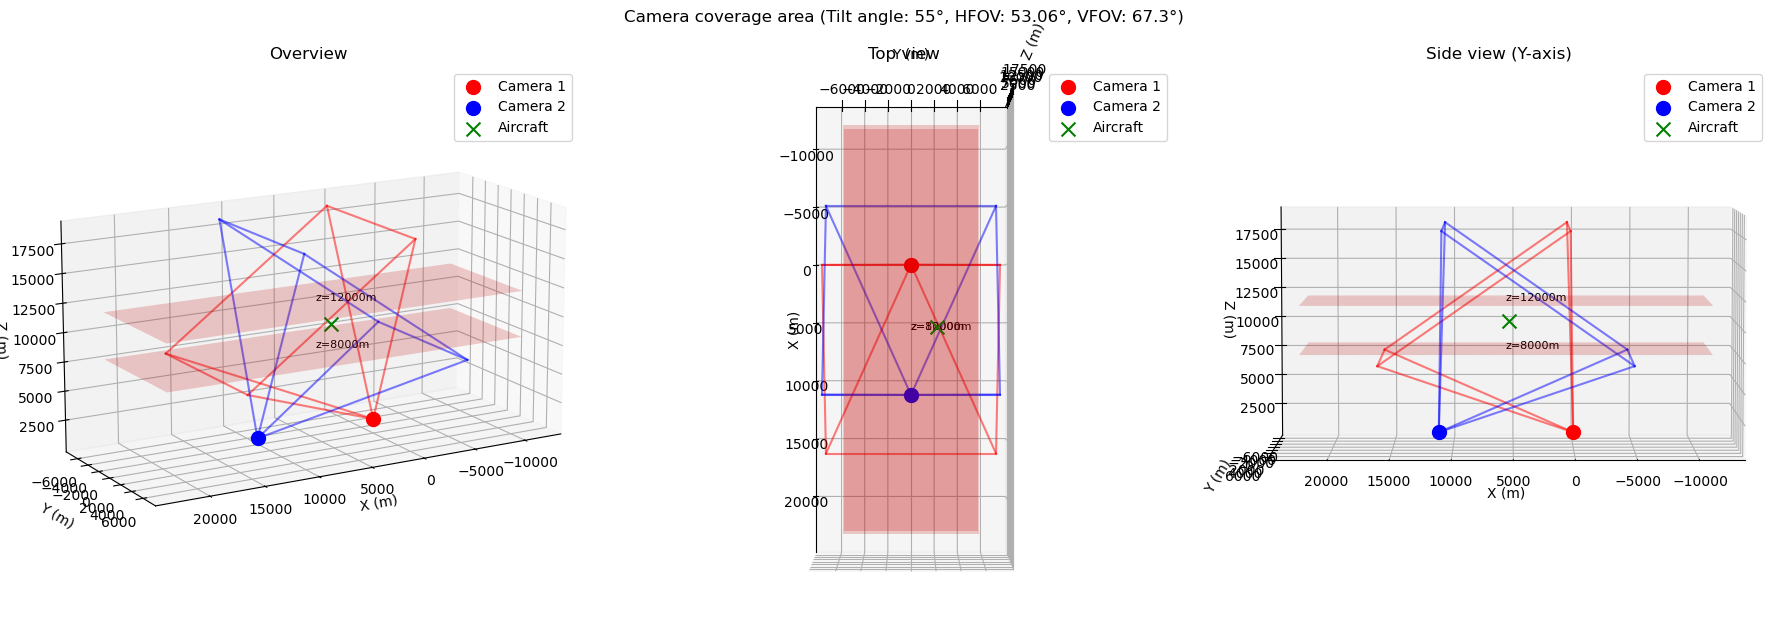

In [22]:
def plot_camera_coverage(D, camera1_pos, camera2_pos, tilt_angle, hfov, vfov, view_angles, plane_heights, aircraft_position):
    fig = plt.figure(figsize=(18, 6))
    
    # Create 3 subplots for 3 different viewing angles
    plots = []
    for i, (elev, azim) in enumerate(view_angles):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        plots.append(ax)
        
        # Plot camera positions
        ax.scatter(camera1_pos[0], camera1_pos[1], camera1_pos[2], color='red', s=100, label='Camera 1')
        ax.scatter(camera2_pos[0], camera2_pos[1], camera2_pos[2], color='blue', s=100, label='Camera 2')
        
        # Plot aircraft position
        ax.scatter(aircraft_position[0], aircraft_position[1], aircraft_position[2], 
                   color='green', s=100, label='Aircraft', marker='x')

        # Convert tilt angle and FOV to radians
        tilt_angle_rad = np.radians(tilt_angle)
        hfov_rad = np.radians(hfov)
        vfov_rad = np.radians(vfov)

        # Calculate the direction vector for each camera
        direction1 = np.array([np.cos(tilt_angle_rad), 0, np.sin(tilt_angle_rad)])
        direction2 = np.array([-np.cos(tilt_angle_rad), 0, np.sin(tilt_angle_rad)])

        # Calculate and draw frustums (view cones) for each camera
        for pos, direction, color in [(camera1_pos, direction1, 'red'), (camera2_pos, direction2, 'blue')]:
            # Calculate vectors perpendicular to the camera direction
            up = np.array([0, 0, 1])
            right = np.cross(direction, up)
            right = right / np.linalg.norm(right)
            up = np.cross(right, direction)

            # Calculate the vertices of the frustum
            dist = observation_distance  # Length of the frustum
            width = 2 * dist * np.tan(hfov_rad / 2)
            height = 2 * dist * np.tan(vfov_rad / 2)

            top_right = pos + dist * direction + (width / 2) * right + (height / 2) * up
            top_left = pos + dist * direction - (width / 2) * right + (height / 2) * up
            bottom_right = pos + dist * direction + (width / 2) * right - (height / 2) * up
            bottom_left = pos + dist * direction - (width / 2) * right - (height / 2) * up

            # Draw the edges of the frustum
            for start, end in [(pos, top_right), (pos, top_left), (pos, bottom_right), (pos, bottom_left),
                               (top_right, top_left), (top_right, bottom_right),
                               (top_left, bottom_left), (bottom_right, bottom_left)]:
                ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color=color, alpha=0.5)

        # Draw horizontal planes at specified heights
        for height in plane_heights:
            x = np.linspace(-D, D * 2, 100)
            y = np.linspace(-D / 2, D / 2, 100)
            X, Y = np.meshgrid(x, y)
            Z = np.full_like(X, height)
            
            # Plot the plane with light gray color and transparency
            ax.plot_surface(X, Y, Z, alpha=0.2, color='red')
            
            # Add label for the plane
            ax.text(D / 2, 0, height, f'z={height}m', fontsize=8)

        # Set axes labels
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        
        # Set title for each subplot
        if i == 0:
            ax.set_title('Overview')
        elif i == 1:
            ax.set_title('Top view')
        else:
            ax.set_title('Side view (Y-axis)')
            
        ax.legend()

        # Adjust viewing angle
        ax.view_init(elev=elev, azim=azim)

        # Set equal aspect ratio for all axes
        ax.set_box_aspect((np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())))

    plt.suptitle(f'Camera coverage area (Tilt angle: {tilt_angle}°, HFOV: {hfov}°, VFOV: {vfov}°)', y=1.02)
    plt.tight_layout()
    plt.show()

# Define viewing angles (elev, azim) for each subplot
view_angles = [
    (15, 60),    # Overview
    (90, 0),     # Top view
    (5, 90)      # Side view (Y-axis)
]

# Define heights of the planes
plane_heights = [8000, 12000]

plot_camera_coverage(D, camera1_pos, camera2_pos, 55, hfov1, vfov1, view_angles, plane_heights, aircraft_position)

In [23]:
# Calculate the projected distance between camera 1 and the aircraft on the ground
projected_distance = sqrt(aircraft_position[0]**2 + aircraft_position[1]**2)

# Calculate aircraft GPS position
lat_aircraft, lon_aircraft = calculate_gps_coordinates(
    lat1, lon1, projected_distance, (center_orientation1 - degrees(alpha1)) % 360
)
alt_aircraft = aircraft_position[2]

# Print results
print("Aircraft GPS Coordinates:", (lat_aircraft, lon_aircraft, alt_aircraft))
folium.Marker([lat_aircraft, lon_aircraft], popup="Aircraft", icon=folium.Icon(color="orange")).add_to(m)

m

Aircraft GPS Coordinates: (43.52218851300609, 1.4421039526384951, 10505.217259753736)
